# W266 Final Project Code
# Amazon Product Review Aspect-Based Sentiment
## Jennifer Mahle and Joanna Wang (Sections 3 and 1, respectively) 


In [3]:
import os
import pandas as pd

dataset = "Electronics_5.json"

if os.path.isfile(dataset):
    df = pd.read_json("Electronics_5.json", lines=True)
else:
    url = r"http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Electronics_5.json.gz"
    df = pd.read_json(url, compression='gzip', lines=True)

display(df.tail(10))
df.shape
print(df.info())

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
6739580,5,NaN,True,"07 25, 2017",A1OOVLE2KZ6KGA,B01HJCN1EI,NaN,Puddzee,These are my favorite charging cords for a few...,Worth the price.,1500940800,NaN
6739581,1,NaN,True,"04 4, 2017",A77K1B31UAQ29,B01HJCN1EI,NaN,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,1491264000,NaN
6739582,3,NaN,True,"07 8, 2017",A2SVXUVUAWUDK2,B01HJH42KU,NaN,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,1499472000,NaN
6739583,2,NaN,True,"05 21, 2017",A12E1JGKV0ETAB,B01HJH42KU,NaN,John Adams,I liked the length and the product at first bu...,Lost ability to connect.,1495324800,NaN
6739584,3,NaN,True,"06 26, 2017",A1HKXEX8BEQC2E,B01HJH40WU,NaN,Dasha stephens,not holding up over time :(,not holding up over time :(,1498435200,NaN
6739585,4,NaN,True,"03 21, 2017",A33MAQA919J2V8,B01HJH40WU,NaN,Kurt Wurm,"These seem like quality USB cables, time will ...",Four Stars,1490054400,NaN
6739586,4,NaN,True,"01 9, 2017",A1AKHSCPD1BHM4,B01HJH40WU,NaN,C.L Momof3,"Works great, love the longer cord. As with any...",Nice long cord,1483920000,NaN
6739587,5,2,True,"12 1, 2016",A2HUZO7MQAY5I2,B01HJH40WU,NaN,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,1480550400,NaN
6739588,5,2,True,"11 29, 2016",AJJ7VX2L91X2W,B01HJH40WU,NaN,Faith,Works well.,Five Stars,1480377600,NaN
6739589,5,NaN,True,"03 31, 2017",A1FGCIRPRNZWD5,B01HJF704M,NaN,Brando,I have it plugged into a usb extension on my g...,Works well enough..,1490918400,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6739590 entries, 0 to 6739589
Data columns (total 12 columns):
overall           int64
vote              object
verified          bool
reviewTime        object
reviewerID        object
asin              object
style             object
reviewerName      object
reviewText        object
summary           object
unixReviewTime    int64
image             object
dtypes: bool(1), int64(2), object(9)
memory usage: 572.0+ MB
None


In [4]:
df = df.dropna(subset=['reviewText'])
df.shape

(6738237, 12)

In [17]:
df_mini= df.sample(n=600)
df_mini.shape

(600, 12)

In [18]:
df_mini["preprocessed"] = df_mini["reviewText"].str.replace(pat='$$', repl="money", regex=True)

print(df_mini["preprocessed"].iloc[50])

If fit my ipod. You get two. What else you can ask for it.money


In [19]:
print(df_mini.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 4701993 to 384544
Data columns (total 13 columns):
overall           600 non-null int64
vote              94 non-null object
verified          600 non-null bool
reviewTime        600 non-null object
reviewerID        600 non-null object
asin              600 non-null object
style             323 non-null object
reviewerName      600 non-null object
reviewText        600 non-null object
summary           600 non-null object
unixReviewTime    600 non-null int64
image             11 non-null object
preprocessed      600 non-null object
dtypes: bool(1), int64(2), object(10)
memory usage: 61.5+ KB
None


In [8]:
# Remove ## from lines starting with ! and run them the first time to install necessary packages 

##%%capture
# Install the latest Tensorflow version.
!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
!pip3 install tensorflow-hub
!pip3 install seaborn
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)


Requirement already up-to-date: tensorflow-gpu in /home/wangjia/anaconda3/lib/python3.7/site-packages (2.1.0)


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [20]:
#split the data into training and testing data, using "overall" as the target variable
y=df_mini.overall
x=df_mini.drop('overall',axis=1)


In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (480, 12)
y_train shape: (480,)

x_test shape: (120, 12)
y_test shape: (120,)



In [22]:
reviews_messages = x_train.reviewText
message_embeddings = embed(reviews_messages)


In [23]:
reviews_messages_array = np.array(reviews_messages)

In [24]:
reviews_messages_array[1]

'Got it to use with Suddenlink It works on my 200mb connection'

In [25]:
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(reviews_messages_array[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: I have only had this camera about a week, but after overcoming Sunba's bonehead default configuration, I finally got it configured and running. I am very pleased with the picture and optics, but control and configuration software is both difficult and confusing. Also, as usual with electronics made overseas, the little manual that comes with the camera is laughable, and useless.  Additionally, the camera is very heavy, which presents mounting difficulties. Even with the great optics, using this camera is tainted by the pathetic configuration problems.

What is that pathetic default configuration? Well, Sunba preloads the camera with a default network ip address. Which might be fine and dandy, if your camera network is using the same subnet as the preconfigured address in the camera, but if your network is configured for a different subnet then you have to figure out how to get around it, and for the average person I suspect it would be very difficult to do (I had to configure 

In [15]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)

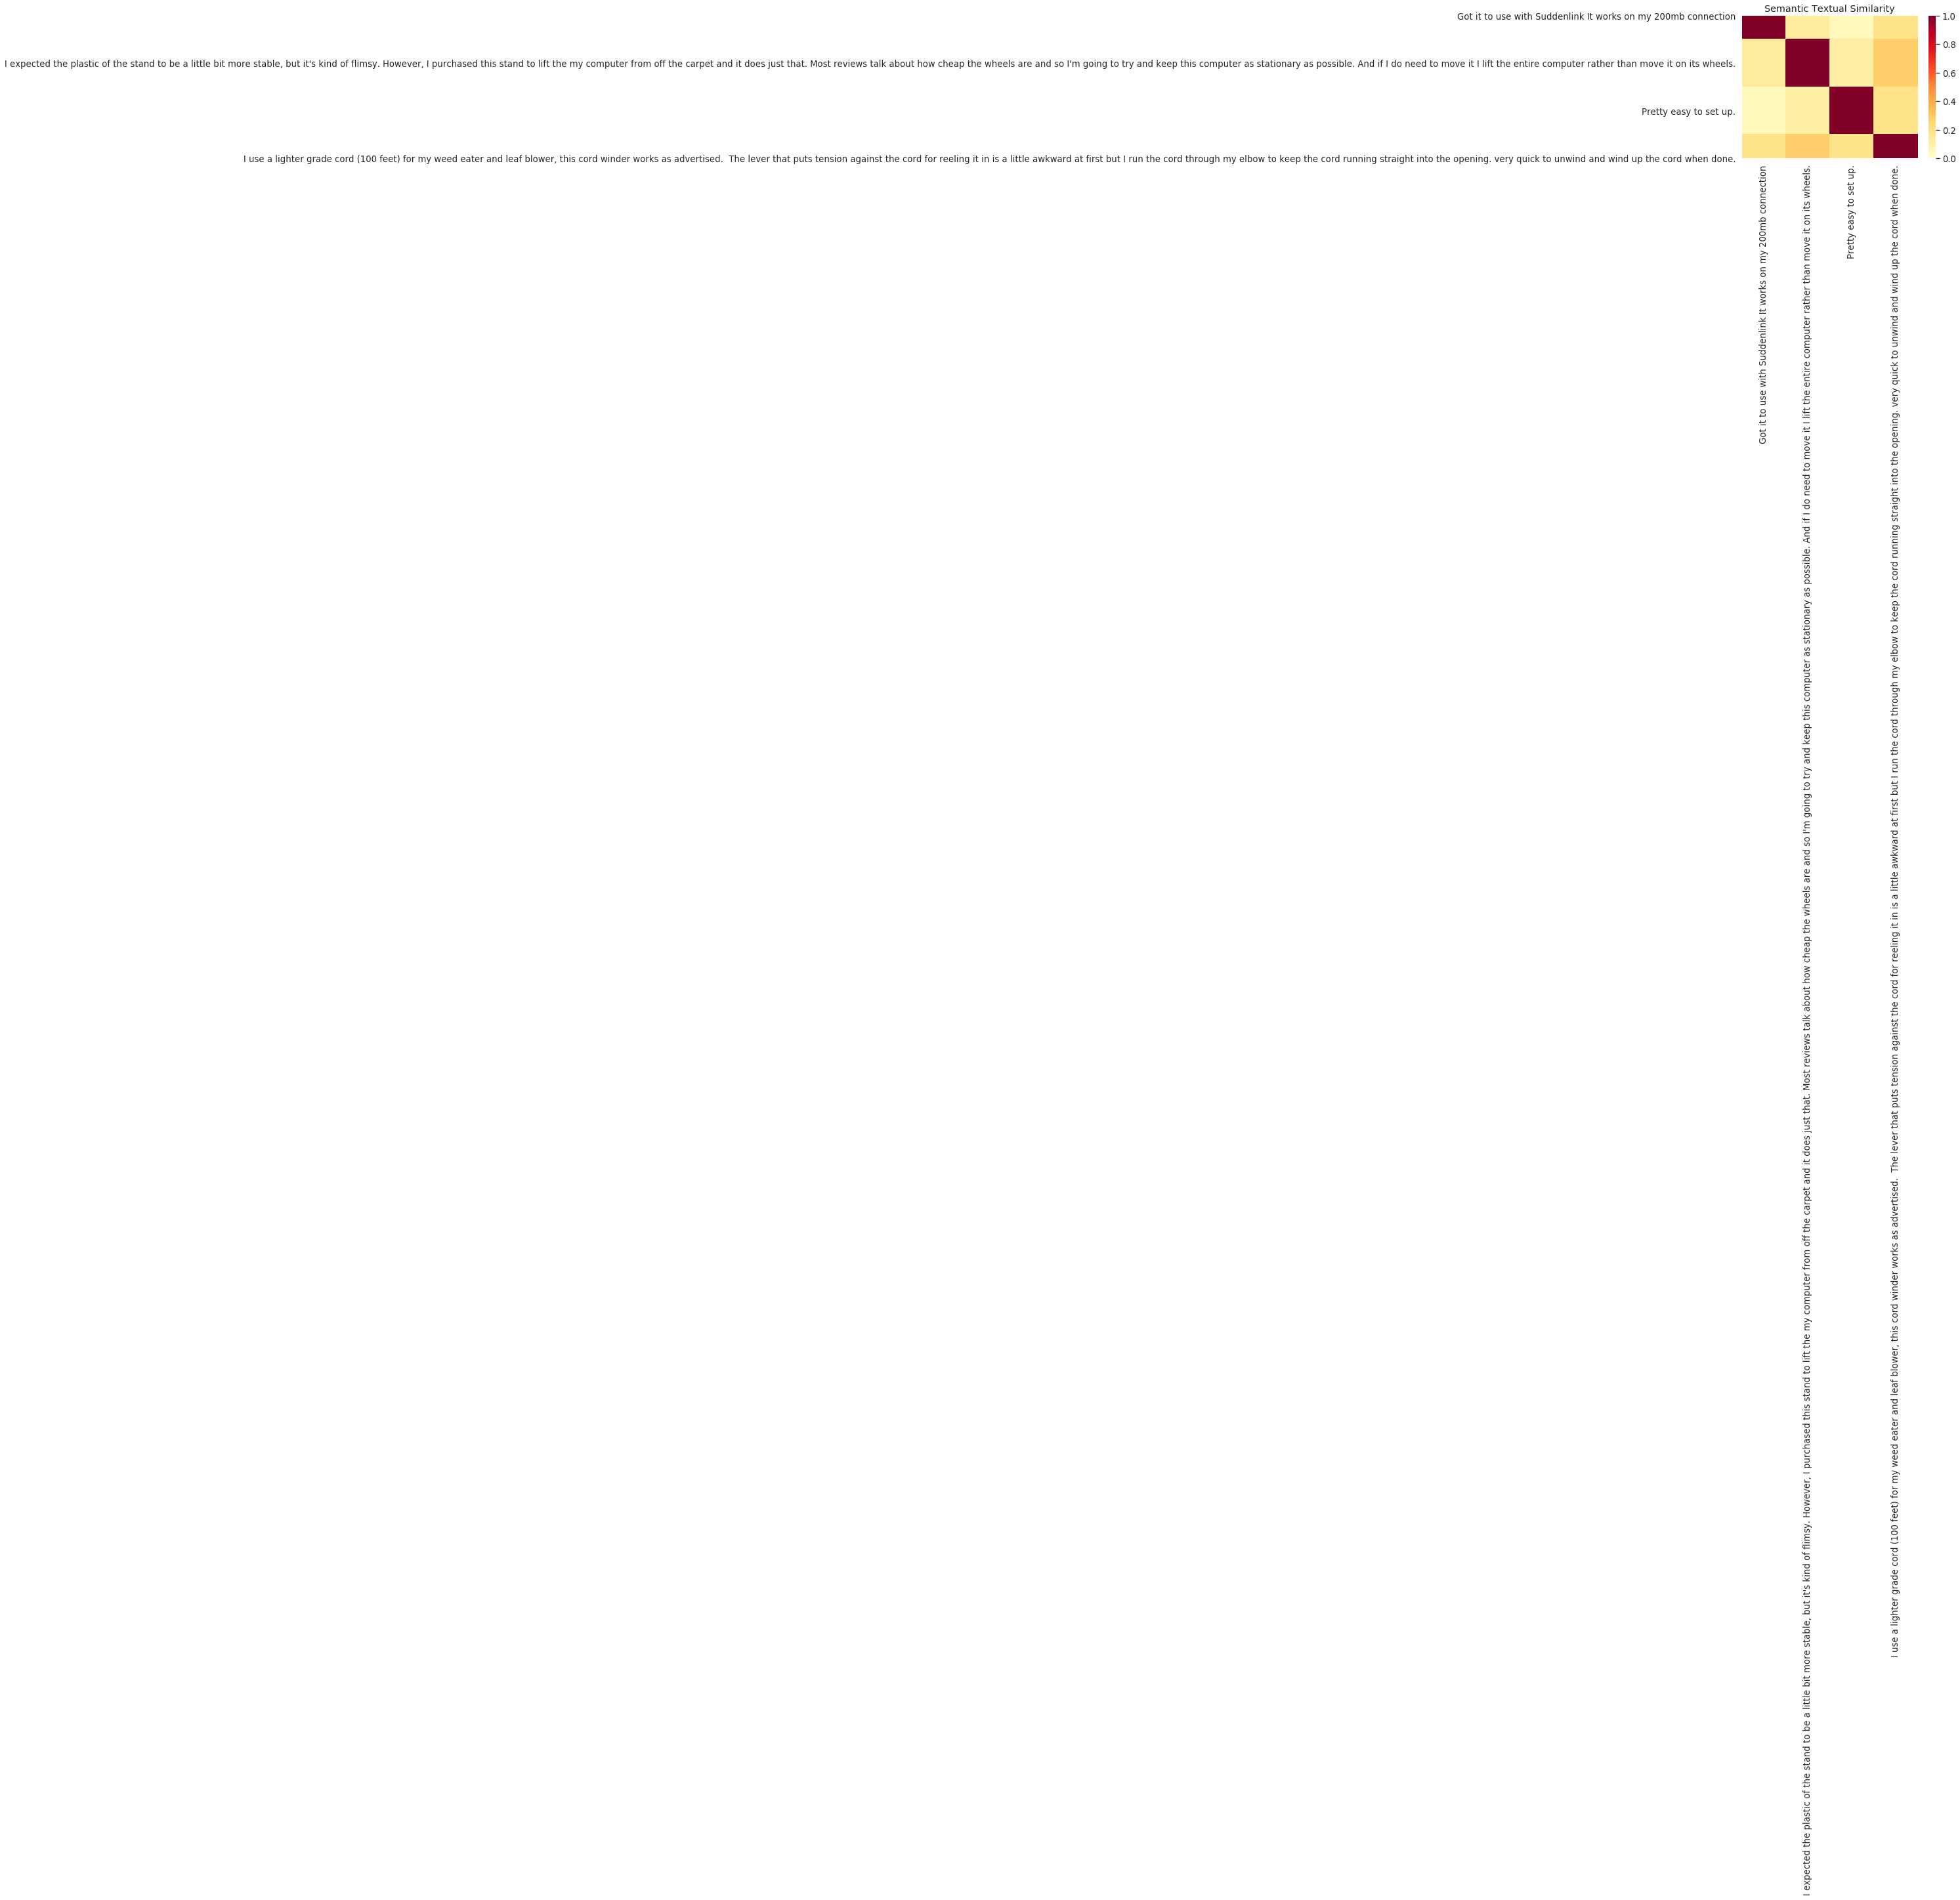

In [28]:
run_and_plot(reviews_messages_array[1:5])


## Sentiment section

In [29]:
print(df_mini.isnull().sum())


overall             0
vote              506
verified            0
reviewTime          0
reviewerID          0
asin                0
style             277
reviewerName        0
reviewText          0
summary             0
unixReviewTime      0
image             589
preprocessed        0
dtype: int64


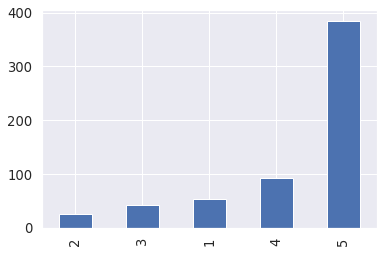

In [30]:
df_mini["overall"].value_counts().sort_values().plot.bar()


In [32]:
senti= df_mini[df_mini["overall"].notnull()]
df_mini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 4701993 to 384544
Data columns (total 13 columns):
overall           600 non-null int64
vote              94 non-null object
verified          600 non-null bool
reviewTime        600 non-null object
reviewerID        600 non-null object
asin              600 non-null object
style             323 non-null object
reviewerName      600 non-null object
reviewText        600 non-null object
summary           600 non-null object
unixReviewTime    600 non-null int64
image             11 non-null object
preprocessed      600 non-null object
dtypes: bool(1), int64(2), object(10)
memory usage: 61.5+ KB


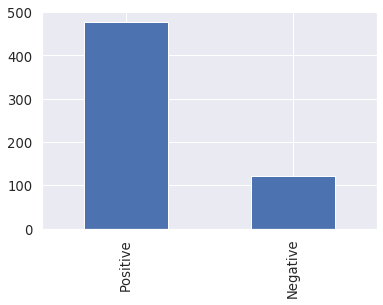

In [33]:
senti["senti"] = senti["overall"]>=4
senti["senti"] = senti["senti"].replace([True , False] , ["Positive" , "Negative"])
senti["senti"].value_counts().plot.bar()

In [36]:
ndf=pd.read_csv("./negative.csv")
neg_words= list(ndf["words"])
pdf=pd.read_csv("./pos.csv")
pos_words= list(pdf["words"])

In [38]:
def sentiment(r):
    neg_no=0
    pos_no=0
    nut_no=0
    #for review in r:
    token_words=word_tokenize(r)
    print(token_words)
    token_words=[''.join(c for c in s if c not in string.punctuation)for s in token_words]
    useful_words = [word for word in token_words if word not in stopwords.words("english")]
    for w in useful_words:
        if w in neg_words:
            neg_no +=1
        elif w in pos_words:
            pos_no +=1
        else:
            nut_no +=1
    if pos_no>neg_no:
        return +1
    elif neg_no>pos_no:
        return -1
    else:
        return 0

In [39]:
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

In [40]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/wangjia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/wangjia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
pos_review=0
neg_review=0
nut_review=0
for review in df_mini["reviewText"]:
    counter=sentiment(review)
    if counter==-1:
        neg_review +=1
    elif counter==1:
        pos_review +=1
    else:
        nut_review +=1
print(pos_review,neg_review,nut_review)

['Great', 'little', 'camera', '.', 'I', "'ve", 'had', 'it', 'quite', 'a', 'while', 'now', '.', 'It', 'takes', 'great', 'pictures', 'and', 'is', 'easy', 'to', 'use', '.']
['got', 'this', 'today', 'and', 'i', "'m", 'impress', 'so', 'far', '.', 'It', "'s", 'surprisingly', 'small', '..so', 'happy', 'about', 'that', 'cause', 'its', 'taking', 'less', 'space', 'on', 'my', 'desk', '.', 'all', 'my', 'devices', 'are', 'connected', 'without', 'any', 'problems', ',', 'its', 'really', 'nice', ',', 'portable', '(', 'light', ')', 'like', 'the', 'fact', 'that', 'its', 'slides', 'out', 'of', 'the', 'base', ',', 'very', 'affordable', 'and', 'got', 'here', 'in', 'one', 'piece', '.', 'so', 'far', 'I', "'m", 'really', 'satisfied', 'with', 'this', 'product', '.', 'besides', 'that', 'i', 'dislike', 'the', 'fact', 'my', 'external', 'hard', 'drive', 'can', 'only', 'be', 'read', 'when', 'its', 'connected', 'to', 'the', 'AC', 'unit', '(', 'guess', 'the', 'power', 'via', 'usb', 'is', 'not', 'powerful', 'enough', 

['We', 'love', 'these', '.', 'They', 'are', 'the', 'only', 'cords', 'our', 'cats', 'do', "n't", 'chew', 'and', 'they', 'are', 'super', 'long', '.', 'I', 'would', 'have', 'given', 'them', 'five', 'stars', 'but', 'they', 'stop', 'working', 'kind', 'of', 'easily', '(', 'short', 'out', 'or', 'become', 'loose', 'when', 'plugged', 'into', 'the', 'phone', ')', ',', 'but', 'are', 'cheap', 'enough', 'to', 'replace', '.']
['good', 'product']
['My', 'favorite', 'lens', '.', 'This', 'is', 'the', 'lens', 'that', 'I', 'use', 'most', '.', 'This', 'lens', 'is', 'extremely', 'versatile', 'and', 'is', 'a', 'great', 'choice', 'for', 'everyday', 'shooting', '.', 'It', "'s", 'wide', 'angle', 'with', 'both', 'zoom', 'and', 'macro', 'capability', '.', 'All', 'bases', 'are', 'covered', 'with', 'just', 'this', 'one', 'lens', '.', 'That', "'s", 'not', 'to', 'say', 'this', 'is', 'the', 'only', 'lens', 'you', "'ll", 'ever', 'want', 'or', 'need', ',', 'but', 'it', 'will', 'likely', 'be', 'the', 'most', 'essential'

['Does', 'the', 'job', 'to', 'daisy', 'chain', 'two', 'DVI-I', 'cables', 'together', '.', 'nothing', 'else', 'to', 'it', '.']
['This', 'review', 'is', 'for', 'the', 'Slappa', 'DSLR', 'Backpack', 'All', 'I', 'can', 'say', 'is', 'do', 'not', 'buy', 'this', 'backpack', '.', 'I', 'have', 'bought', 'it', 'twice', 'and', 'have', 'been', 'forced', 'to', 'return', 'it', 'both', 'times', '.', 'The', 'pack', 'has', 'a', 'massive', 'design', 'flaw', '.', 'The', 'back', 'compartment', 'is', 'removable', '.', 'When', 'removed', 'it', 'exposes', 'the', 'camera', 'equipment', 'stored', 'in', 'middle', 'portion', 'of', 'the', 'pack', '.', 'This', 'would', "n't", 'be', 'a', 'problem', '(', 'and', 'in', 'fact', 'a', 'bit', 'handy', ')', 'BUT', 'the', 'zipper', '(', 'on', 'both', 'packs', ')', 'was', 'defective', '.', 'The', 'end', 'of', 'the', 'zipper', 'falls', 'off', ',', 'the', 'pack', 'unzips', 'from', 'the', 'bottom', 'which', 'could/will', 'cause', 'your', 'camera', 'equipment', 'to', 'fall', 'out

['Great', 'Stylus', '(', 'Note', ':', 'Friendly', 'Swede', 'Replacement', 'Tips', 'Fit', 'the', 'iFrog', 'Stylus', ')', 'Update', ':', 'I', 'have', 'discovered', 'that', 'Friendly', 'Swede', 'Replacement', 'Tips', 'available', 'on', 'Amazon.com', 'fit', 'the', 'iFrogz', 'stylus', '!', '!', '!', 'Original', 'Review', ':', 'This', 'is', 'a', 'good', 'stylus', ',', 'however', ',', 'you', 'need', 'to', 'realize', 'the', 'conductive', 'rubber', 'tip', 'is', 'NOT', 'indestructible', '.', 'It', "'s", 'lifetime', 'depends', 'on', 'how', 'much', 'or', 'how', 'hard', 'it', 'is', 'used', '.', 'This', 'stylus', 'will', 'do', 'everything', 'you', 'expect', 'and', 'increases', 'your', 'accuracy', 'significantly', 'over', 'using', 'your', 'finger', '.', 'From', 'my', 'experience', ',', 'I', 'can', 'get', 'approximately', 'four', 'or', 'more', 'months', 'from', 'an', 'iFrogz', 'stylus', 'using', 'them', 'fairly', 'hard', '.', 'I', 'wish', 'iFrogz', 'would', 'include', 'or', 'sell', 'replacement', 'tip

['Slim', 'Fit', ',', 'simple', ',', 'Manufactured', 'Carefully', ',', 'with', 'sense', 'of', 'elegance', ',', 'Good', 'choice', 'for', 'people', 'who', 'want', 'thin', ',', 'simple', '&', 'elegant', 'cover', 'at', 'the', 'same', 'time', ',', 'sleep/wake', 'function', 'works', 'Punctually', '!']
['great', 'little', 'tv', '.', 'i', 'use', 'it', 'as', 'a', '3rd', 'screen', 'for', 'my', 'computer']
['For', 'wedding', 'shooting', 'I', 'no', 'longer', 'have', 'to', 'leave', 'my', 'bag', 'with', 'the', 'DJ', '.', 'I', 'have', 'my', 'bag', 'on', 'my', 'belt', '(', 'both', 'hands', 'free', ')', '.']
['Nice', 'little', 'case', '.', 'Snaps', 'together', 'firmly', '.']
['These', 'are', 'by', 'far', 'the', 'most', 'expensive', 'and', 'best', 'earphones', 'I', 'have', 'ever', 'bought', '.', 'I', "'m", 'pretty', 'frugal', 'so', 'do', "n't", 'hate', '.', 'I', 'love', 'to', 'listen', 'to', 'good', 'quality', 'music', 'any', 'time', 'I', 'get', 'the', 'chance', 'and', 'these', 'headphones', 'seriously',

['Very', 'roomy', 'light', 'backpack', '-', 'perfect', 'for', 'day', 'hikes', '-', 'have', "n't", 'tested', 'it', 'in', 'heavy', 'rain', 'but', 'it', 'protected', 'the', 'things', 'inside', 'in', 'a', 'steady', 'light', 'rain', 'for', 'about', 'an', 'hour', '.', 'Seller', 'is', 'perfect', '-', 'this', 'was', 'a', 'replacement', 'for', 'a', 'pack', 'I', "'d", 'bought', '2', 'years', 'about', 'and', 'they', 'refunded', 'my', 'cost', 'and', 'upheld', 'the', 'lifetime', 'warranty', '-', 'you', 'ca', "n't", 'go', 'wrong', 'with', 'this', 'pack', '.']
['Very', 'useful', 'tool', 'to', 'have', '.']
['This', 'box', 'came', 'with', 'Windows', 'XP', 'Pro', 'on', 'the', 'HDD', '.', 'There', 'was', 'an', 'issue', 'with', 'the', 'OS', ',', 'so', 'I', 'contacted', 'the', 'seller', '.', 'The', 'seller', 'responded', 'very', 'quickly', ',', 'and', 'suggested', 'sending', 'me', 'another', 'HDD', 'with', 'prepaid', 'return', 'label', 'for', 'the', 'one', 'with', 'the', 'defective', 'OS', '.', 'That', 'wo

['The', 'sound', 'of', 'this', 'unit', 'is', 'very', ',', 'very', 'good', '.', 'Deep', 'bass', 'and', 'clear', 'tone', '.', 'The', 'external', 'MP3', 'input', 'is', 'good', ',', 'but', 'difficult', 'to', 'calibrate', 'for', 'good', 'output', '.', 'Very', 'low', 'sound', 'output', ',', 'but', 'I', "'m", 'still', 'experimenting', 'with', 'it', '.', 'The', 'FM', 'reception', 'is', 'poor', 'at', 'best', '.', 'Lots', 'of', 'static', 'on', 'stations', 'that', 'I', 'thought', 'were', 'strong', 'in', 'our', 'area', '.', 'I', 'guess', 'you', 'ca', "n't", 'have', 'it', 'all', '.']
['The', 'sound', 'quality', 'is', 'beautiful', ',', 'and', 'I', 'like', 'the', 'fact', 'that', 'it', 'plays', 'MP3', 'files', '.', 'The', 'control', 'buttons', 'are', 'tiny', ',', 'so', 'given', 'my', 'elderly', 'eyesight', 'I', 'had', 'to', 'make', 'a', 'crib', 'sheet', 'for', 'which', 'button', 'does', 'what', '.']
['Super', 'bright', '.', 'Barn', 'doors', 'are', 'very', 'useful', '.', 'Brightness', 'knob', 'works', 

['Cheapest', 'price', 'on', 'the', 'net', '!', 'Works', 'great', '!']
['A', 'high-value', 'item', 'not', 'perfect', ',', 'but', 'compared', 'to', 'the', '$', '600', 'Wimberly', 'which', 'is', 'its', 'closest', 'competition', ',', 'a', 'great', 'deal', '.', 'Pros', ':', '1', ')', 'handles', 'very', 'heavy', 'lenses', 'and', 'makes', 'them', 'almost', 'weightless', 'if', 'properly', 'set', 'up', '2', ')', 'works', 'very', 'well', 'with', 'Minolta', '600', 'F4', 'which', 'is', 'a', 'massive', '12.5', 'pound', 'lens', 'and', 'I', 'assume', 'functions', 'similarly', 'with', 'other', '600', 'mm', 'large', 'aperture', 'behemoths', '.', '3', ')', 'Easy', 'to', 'adjust', 'so', 'that', 'it', 'moves', 'freely', 'and', 'also', 'so', 'that', 'it', 'can', 'be', 'locked', 'down', 'both', 'in', 'the', 'tilt', 'and', 'pan', 'directions', '.', '4', ')', 'Tight', 'bearings', 'with', 'little', 'slack', 'Cons', ';', '1', ')', 'Heavy', 'itself', '2', ')', 'not', 'as', 'smooth', 'as', 'the', 'Wimberley', '3'

['Great', 'camera', 'for', 'the', 'price', '.', 'Very', 'useful', '!']
['im', 'not', 'evan', 'runnin', 'this', 'at', 'half', 'the', 'rated', 'power', 'on', 'the', 'sub', '.', 'it', 'sais', '400', 'on', 'the', 'rockford', 'site', 'and', 'i', 'have', '175', 'watts', 'rms', '.', 'it', 'bumps', 'enough', 'to', 'vibrate', 'my', 'afro', 'whenn', 'im', 'driving', '.', 'ive', 'definetly', 'pissed', 'a', 'few', 'ollllll', 'vermonters', 'off', 'with', 'this', '.']
['I', 'love', 'these', 'radios', '!']
['ive', 'had', 'this', 'for', 'almost', 'a', 'year', 'now', 'for', 'my', 'ip', 'cameras', ',', 'no', 'problems']
['Good', 'sturdy', 'cat-6', 'works', 'just', 'fine', 'at400mps', '.']
['This', 'is', 'a', 'quality', 'power', 'supply', 'with', 'a', '10', "'", 'cord', 'that', 'is', 'pretty', 'durable', ',', 'an', 'LED', 'power', 'indicator', ',', 'small', 'size', 'at', 'the', 'powerstrip/wall', 'end', ',', 'and', 'the', 'correct', 'orientation', 'to', 'avoid', 'blocking', 'other', 'outlets', '.', 'Howe

['I', 'have', 'tried', 'several', 'of', 'Bose', 'products', 'before', 'including', 'the', 'QuietComfort-3', 'back', 'in', '2012', '.', 'My', 'son', 'recently', 'got', 'a', 'pair', 'of', 'Beats', 'Solo3', '(', 'wireless', ')', 'and', 'I', 'could', "n't", 'be', 'outdone', 'nor', 'could', 'I', 'go', 'with', 'the', 'same', 'brand', '.', 'After', 'having', 'these', ',', 'my', 'son', 'tried', 'them', 'and', 'wanted', 'to', 'trade', '.', 'The', 'noise', 'cancelling', 'is', 'what', 'I', 'would', 'expect', 'from', 'Bose', '-', 'awesome', '.', 'The', 'Beats', 'Studio', 'wireless', 'do', "n't", 'even', 'come', 'close', 'and', 'actually', 'gave', 'me', 'a', 'headache', '.', 'The', 'padding', 'on', 'these', 'is', 'soft', 'like', 'a', 'pillow', '.', 'I', 'watched', 'an', 'Amazon', 'video', 'on', 'my', 'iPad', 'in', 'a', 'room', 'with', 'others', 'just', 'because', 'they', 'were', 'so', 'comfortable', '.']
['Performs', 'as', 'advertised', '.']
['I', 'have', 'owned', 'my', 'ZVM', 'for', 'a', 'few', 'm

['because', 'it', 'has', 'its', 'own', 'OS', 'and', 'im', 'used', 'to', 'windows', 'and', 'office', 'I', 'have', 'some', 'difficulty', '.', 'I', 'use', 'it', 'as', 'a', 'frontroom', 'pc', '.', 'I', 'just', 'love', 'going', 'to', 'the', 'net', 'when', 'I', 'do', "n't", 'know', 'a', 'word', 'or', 'the', 'weather', 'or', 'just', 'check', 'email', '.', 'for', 'serious', 'work', 'the', 'desk', 'top', 'and', 'office', 'is', 'my', 'game', 'but', 'this', 'will', 'keep', 'you', 'going', '.', 'looks', 'good', ',', 'feels', 'great', ',', 'and', 'yes', 'im', 'glad', 'I', 'bought', 'it']
['Simple', 'and', 'easy', 'to', 'install', '.', 'Driving', '2', '5.25', 'RF', 'punch', 'speakers', 'and', 'they', 'sound', 'great', '.']
['I', 'went', 'to', 'Amazon', 'thinking', 'that', 'it', 'might', 'carry', 'a', 'promotional', 'offer', 'for', 'a', 'cut', 'rate', 'on', 'a', 'Google', 'Play', 'Card', '.', 'I', "'m", 'a', 'bit', 'dumbfounded', 'to', 'see', 'that', 'somehow', 'Amazon', 'wants', 'to', 'charge', 'a',

['Way', 'cheaper', 'than', 'renting', 'from', 'Comcast', '!']
['These', 'shields', 'provide', 'good', 'coverage', 'for', 'surface', 'pro', '4', 'however', 'hard', 'to', 'install', ',', 'card', 'provide', 'was', 'not', 'sufficient', 'enough', 'to', 'smooth', 'shield', ',', 'I', 'had', 'to', 'use', 'a', 'debit', 'card', '.']
['It', 'is', 'a', 'great', 'processor', 'for', 'the', 'money', ',', 'to', 'run', 'the', 'games', 'currently', 'in', 'the', 'market', 'it', 'is', 'more', 'than', 'enough', '.', 'Perfect', 'for', 'a', 'decent', 'power', 'desktop', 'configuration', 'for', 'gaming', 'and', 'a', 'big', 'bang', 'for', 'Office', 'duties', '.']
['It', 'works', 'perfect', 'for', 'my', 'needs', '.', 'If', 'you', 'have', 'a', 'larger', 'room', 'I', 'recommend', 'you', 'get', 'the', 'other', 'model', '.', 'It', 'turns', 'on', 'right', 'when', 'the', 'sun', 'goes', 'down', '.', 'Give', 'it', 'try', 'you', "'d", 'swear', 'someone', 'was', 'watching', 'tv', 'in', 'your', 'room', '.']
['Does', 'what

['I', 'have', 'no', 'clue', 'what', 'this', 'thing', 'is', 'but', 'my', '11', 'year', 'old', 'son', 'had', 'to', 'have', 'it', 'for', 'Christmas', '.', 'He', 'wanted', 'it', 'to', 'record', 'things', 'off', 'of', 'his', 'xbox', 'one', 'and', 'xbox', '360', 'and', 'post', 'on', 'his', 'YouTube', 'account', '.', 'But', 'we', 'can', 'not', 'figure', 'it', 'out', 'at', 'all', '.', 'We', 'will', 'most', 'likely', 'be', 'returning', 'it', '!']
['Bought', 'this', 'router', '9', 'months', 'ago', '.', 'First', 'one', 'did', 'not', 'work', '(', 'right', 'out', 'of', 'the', 'box', 'with', 'security', 'wide', 'open', ')', '.', 'Spent', 'an', 'hour', 'with', 'Technical', 'Support', 'and', 'they', 'confirmed', 'it', 'is', 'defective', '.', 'Returned', 'the', 'product', 'to', 'the', 'Retailer', 'and', 'got', 'a', 'new', 'one', '.', 'Rating', 'of', 'Technical', 'Support', ':', '4.5', 'Star', 'Second', 'one', ':', 'It', 'worked', 'for', '5', 'months', 'and', 'started', 'dropping', 'the', 'connections',

['They', 'were', 'full', 'of', 'static', 'when', 'I', 'pulled', 'them', 'out', 'of', 'the', 'wrapping', '.', 'Meaning', ',', 'lint', 'was', 'sticking', 'to', 'them', 'even', 'after', 'wiping', 'them', '.', 'In', 'conclusion', ',', 'have', "n't", 'used', 'them', '.']
['it', 'works', 'like', 'it', 'should', '!', 'Very', 'durable', 'and', 'good', 'quality', '!', 'What', 'can', 'you', 'say', 'about', 'a', 'cable', '!', 'It', 'works', 'like', 'it', 'should', '!']
['My', 'husband', 'and', 'I', 'purchased', 'this', 'surge', 'protector', 'for', 'our', 'kitchen', ',', 'where', 'it', 'lives', 'just', 'above', 'my', 'built-in', 'desk', '.', 'We', 'needed', 'something', 'that', 'would', 'permanently', 'house', 'the', 'plugs', 'for', 'our', 'cordless', 'phone', 'and', 'answering', 'machine', 'yet', 'also', 'be', 'available', 'for', 'recharging', 'our', 'cell', 'phones', ',', 'iPod', ',', 'and', 'my', 'netbook', 'computer', '.', 'This', 'unit', 'has', 'served', 'our', 'purpose', 'well', '.', 'The', 

['I', 'purchased', 'this', 'briefcase', 'to', 'replace', 'a', 'sleeve', 'laptop', 'case', 'that', 'did', 'not', 'have', 'a', 'handle', 'or', 'strap', '.', 'One', 'of', 'the', 'reviews', 'said', 'this', 'case', 'was', 'not', 'padded', 'on', 'the', 'bottom', ',', 'and', 'I', 'almost', 'did', 'not', 'order', 'it', 'for', 'that', 'reason', '.', 'But', 'the', 'case', 'I', 'received', 'does', 'have', 'bottom', 'padding', ',', 'as', 'well', 'as', 'padding', 'on', 'all', 'sides', 'and', 'the', 'top', '.', 'My', '17', "''", 'laptop', 'fits', 'perfectly', 'in', 'the', 'laptop', 'section', ',', 'and', 'the', 'other', 'section', 'has', 'plenty', 'of', 'space', 'for', 'the', 'power', 'cord', ',', 'mouse', ',', 'pens', ',', 'pencils', ',', 'small', 'paper', 'pads', ',', 'etc', '.', 'Very', 'well', 'designed', 'and', 'constructed', '.']
['Records', 'fine', 'without', 'any', 'problems', 'and', 'the', 'lightscribe', 'works', 'great', '.', 'Material', 'is', 'very', 'thin', '(', 'can', 'see', 'through', 

['The', 'coaxial', 'port', 'on', 'my', 'tv', 'was', 'hard', 'to', 'get', 'to', '.', 'This', 'right', 'angel', 'adapter', 'made', 'it', 'a', 'lot', 'easier', 'for', 'me', 'to', 'attach', 'the', 'coaxial', 'cord', 'to', 'my', 'tv', '.']
['Its', 'small', ',', 'but', 'the', 'ports', 'are', 'too', 'close', 'together', '.', 'I', 'can', 'only', 'fit', '2', 'jump', 'drives/usb', 'adapters', 'into', 'it', ',', 'leaving', '2', 'ports', 'I', 'ca', "n't", 'use', 'for', 'jump', 'drives', '.', 'Only', 'small', 'usb', 'cords', 'will', 'fit', 'in', 'those', 'slots', 'now', '.', 'Would', 'have', 'been', 'more', 'functional', 'with', 'just', 'a', '1/2', "''", 'extra', 'length', '.', 'I', 'have', 'all', 'kingston', 'and', 'transcend', 'USB', 'drives', 'and', 'they', 'do', "n't", 'fit', 'side', 'by', 'side', '.', 'Frustrating', '.', 'Received', 'this', 'as', 'a', 'gift', 'at', 'my', 'own', 'request', '.', 'May', 'return', 'it', ',', 'not', 'sure', 'yet', '.']
['I', 'ordered', 'a', 'desktop', 'specifically

['My', '2010', 'Macbook', 'Pro', 'was', 'really', 'starting', 'to', 'bog', 'down', '.', 'I', 'just', 'figured', 'it', 'was', 'par', 'for', 'the', 'course', ',', 'but', 'my', 'brother', 'suggested', 'upgrading', 'the', 'hard', 'drive', 'to', 'an', 'SSD', 'and', 'I', 'am', 'really', 'glad', 'I', 'took', 'his', 'advice', '.', 'There', 'are', 'great', 'tutorials', 'available', 'online', 'to', 'show', 'you', 'how', 'to', 'do', 'the', 'swap', 'on', 'your', 'own', ',', 'and', 'the', 'special', 'tools', 'you', 'need', 'are', 'available', 'here', 'on', 'Amazon', '.', 'I', 'bought', 'the', 'appropriate', 'tools', 'and', 'have', 'used', 'them', 'a', 'couple', 'of', 'times', 'on', 'various', 'upgrades', 'including', 'this', 'hard', 'drive', 'as', 'well', 'as', 'replacing', 'my', 'LCD', 'screen', 'which', 'had', 'cracked', '.', 'Anyway', ',', 'the', 'performance', 'was', 'immediately', 'and', 'staggeringly', 'noticeable', '.', 'Startup', 'was', 'lightning', 'fast', ',', 'and', 'operation', 'was', '

['Have', 'had', 'this', 'router', 'for', 'some', 'time', 'and', 'I', 'love', 'it', '.', 'It', 'does', 'have', 'a', 'few', 'minor', 'problems', '.', 'However', ',', 'they', 'can', 'be', 'fixed', 'and', 'are', 'being', 'fixed', 'in', 'new', 'firmware', '.', 'Also', ',', 'third-party', 'firmware', 'for', 'this', 'router', 'ca', "n't", 'be', 'beat', '.', 'Firmware', 'can', 'add', 'many', 'new', 'features', 'not', 'advertised', 'for', 'the', 'WRT54G', '.', 'Speed', 'for', 'this', 'router', 'is', 'average', '.', 'Speed', 'can', 'be', 'slightly', 'increased', 'through', 'new', 'firmware', '.', 'At', 'times', 'it', 'can', 'get', 'warm', 'but', 'nothing', 'out', 'of', 'the', 'average', '.', 'Support', 'is', 'okay', 'from', 'Linksys', '.', 'If', 'you', 'have', 'problems', 'they', 'are', 'pretty', 'good', 'at', 'helping', 'you', 'or', 'exchanging', 'your', 'router', '.', 'It', 'matches', 'with', 'other', 'Linksys', 'products', 'with', 'can', 'save', 'space', 'and', 'looks', 'pretty', 'nice', '.',

['I', 'bought', 'this', 'television', 'after', 'lots', 'of', 'research', '.', 'It', 'came', 'down', 'to', 'this', 'one', 'and', 'the', 'Vizio', 'with', 'apps', 'tv', 'as', 'well', '.', 'I', "'m", 'glad', 'I', 'choose', 'this', 'one', '.', 'First', 'off', 'let', 'me', 'say', 'how', 'beautiful', 'this', 'tv', 'looks', 'even', 'when', 'it', "'s", 'not', 'turned', 'on', '.', 'If', 'I', 'could', 'compare', 'it', 'to', 'something', 'I', 'would', 'say', 'it', 'looks', 'like', 'a', '32', 'inch', 'iPad', '.', 'The', 'screen', 'sits', 'behind', 'an', 'all', 'glass', 'front', '.', 'So', 'you', 'can', 'clean', 'the', 'screen', 'with', 'ease', '.', 'Once', 'you', 'turn', 'this', 'beauty', 'on', 'its', 'a', 'gem', '.', 'The', 'picture', 'is', 'stunning', 'and', 'if', 'you', 'do', "n't", 'like', 'the', 'Sony', 'logo', 'that', 'glows', 'on', 'the', 'bottom', 'of', 'the', 'tv', 'while', 'it', "'s", 'on', 'you', 'can', 'turn', 'it', 'off', '.', 'The', 'picture', 'is', 'vibrant', 'and', 'bright', 'and', 

['*update', 'feb.', '5*', 'reduced', 'to', 'one', 'star', ',', 'they', 'do', "n't", 'even', 'connect', 'anymore', '.', 'Absolute', 'junk', ',', 'will', 'never', 'buy', 'coulfax', 'again', '.', 'Bought', 'these', 'in', 'a', 'time', 'pinch', 'for', 'training', 'because', 'my', 'other', 'brand', 'qy8', "'s", 'broke', 'after', 'I', 'stepped', 'on', 'them', 'by', 'accident', '.', 'Not', 'a', 'lot', 'of', 'bass', 'compared', 'to', 'other', 'qy8', 'brands', '.', 'Also', 'the', 'volume', 'is', 'better', 'higher', 'on', 'the', 'right', 'ear', 'verse', 'the', 'left', '.']
['We', 'bought', '2', 'of', 'these', 'floats', 'to', 'protect', 'our', 'Olympus', 'underwater', 'cameras', '.', 'They', 'were', 'delivered', 'quickly', 'and', 'floated', 'the', 'cameras', 'when', 'we', 'took', 'them', 'off', 'our', 'wrist', 'straps', '.']
['What', 'a', 'great', 'case', '!', 'At', 'first', 'I', 'was', "n't", 'expecting', 'the', 'little', 'hinge', 'on', 'the', 'back', 'to', 'put', 'up', 'with', 'me', 'laying', 'm

['I', 'like', 'the', 'mouse', ',', 'it', 'is', 'pretty', 'small', 'but', 'you', 'get', 'used', 'to', 'it', '.', 'My', 'original', 'Apple', 'mouse', 'stopped', 'scrolling', 'up', 'and', 'down', 'and', 'I', 'refuse', 'to', 'pay', '$', '70', 'for', 'a', 'mouse', '.', 'This', 'is', 'the', 'perfect', 'solution', '.']
['Could', 'not', 'carry', 'a', 'strong', 'enough', 'signal', 'to', 'my', 'TV', 'to', 'work', 'the', 'next', 'time', 'my', 'TV', 'turned', 'on', '.']
['Although', 'I', 'do', "n't", 'have', 'any', 'experience', 'with', 'many', 'other', 'bulk', 'cables', ',', 'I', 'really', 'like', 'this', 'one', '.', 'I', 'love', 'how', 'now', 'I', 'can', 'cut', 'wires', 'to', 'exact', 'size', ',', 'non', 'more', 'non', 'less', '.', 'I', 'guess', 'most', 'of', 'the', 'things', 'I', 'love', 'about', 'this', 'product', 'are', 'more', 'aimed', 'towards', 'bulk', 'cable', 'in', 'general', 'and', 'not', 'specifically', 'this', 'Aurum', 'cables', 'product', 'so', 'I', "'ll", 'leave', 'them', 'out', '.'

['I', 'had', 'no', 'problems', 'with', 'this', 'model', '.', 'I', 'read', 'in', 'some', 'reviews', 'that', 'people', 'got', 'it', 'to', 'work', 'on', 'their', 'Comcast', 'network', '.', 'I', 'spent', 'almost', 'a', 'week', 'fighting', 'with', 'Comcast', 'but', 'in', 'the', 'end', 'they', 'told', 'me', 'it', 'was', "n't", 'supported', ',', 'but', 'it', 'maybe', 'in', 'the', 'future', '.', 'Everything', 'worked', 'on', 'my', 'end', ',', 'it', 'connected', ',', 'up', 'and', 'down', 'stream', '.', 'It', 'was', 'just', 'their', 'system', 'seeing', 'the', 'model', 'number', 'and', 'saying', 'no', '.']
['I', 'also', 'have', 'purchased', 'the', '18.5', 'inch', '.', 'Perfect', 'fit', 'for', 'my', 'screens', '.', 'I', 'have', 'dual', 'monitors', 'and', 'needed', 'the', 'glare', 'to', 'be', 'taken', 'out', '.', 'It', 'definitely', 'helped', '.', 'These', 'screens', 'leave', 'a', 'matte', 'finish', 'and', 'it', 'does', "n't", 'hurt', 'that', 'they', 'are', 'privacy', 'filters', '.', 'If', 'you', '

['Good', 'product', ',', 'exact', 'as', 'expected']
['I', 'actually', 'use', 'my', 'little', 'case', 'for', 'clipping', 'my', 'iPod', 'to', 'my', 'running', 'shorts', 'or', 'work', 'shorts', 'or', 'whatever', '.', 'I', 'can', 'still', 'adjust', 'the', 'controls', 'through', 'the', 'vinyl', 'window', '.', 'I', 'like', 'it', '.']
['it', 'is', 'what', 'is', 'says', 'it', 'is', 'and', 'it', 'has', 'been', 'working', 'perfect', 'for', 'about', '2', 'years', 'now', '.']
['Buggy', '.', 'The', 'picture', 'is', 'quite', 'blurry', '.', 'The', 'sound', 'is', 'static', '.', 'Never', 'get', 'movement', 'notifications', '.', 'Cheap', ',', 'better', 'than', 'nothing', '.']
['So', 'far', 'this', 'thing', 'is', 'holding', 'up', 'it', "'s", 'end', 'of', 'the', 'bargain', '.', 'Plenty', 'of', 'power', 'for', 'my', 'IP', 'cams', '.']
['My', 'child', 'has', 'had', 'this', 'since', 'Christmas', 'and', 'it', "'s", 'holding', 'strong', 'no', 'matter', 'how', 'many', 'times', 'it', "'s", 'been', 'dropped', 'or

['My', 'review', 'is', 'on', 'a', 'recent', 'purchase', 'of', 'the', 'Panasonic', 'Blu-ray', 'DMP-BBT01', '.', 'This', 'is', 'an', 'unbelievable', 'Blu-ray', 'player', '.', 'The', 'picture', 'quality', 'on', 'my', '3', 'year', 'old', 'Samsung', '50', "''", 'LCD', 'TV', 'is', 'fantastic', '.', 'I', 'have', 'an', 'older', '6.1', 'surround', 'sound', 'system', 'that', 'does', 'not', 'has', 'an', 'HDMI', 'outlet', 'but', 'does', 'have', 'the', 'digital', 'optical', 'outlet', '.', 'My', 'new', 'Panasonic', 'Blu-ray', 'had', 'the', 'option', 'of', 'using', 'HDMI', 'for', 'sound', 'or', 'digital', 'optical', '.', 'I', 'had', 'to', 'use', 'the', 'digital', 'optical', 'and', 'the', 'sound', 'was', 'heard', 'beautifully', 'in', 'all', '6', 'speakers', '.', 'The', 'wifi', 'connection', 'was', 'easily', 'connected', 'to', 'my', 'Apple', 'router', 'wireless', '.', 'I', 'could', 'hard', 'wire', 'also', 'but', 'did', "n't", 'need', 'to', '.', 'I', 'have', 'great', 'speed', 'with', 'the', 'Apple', '``

['Works', 'as', 'advertised', '.', 'Now', 'turning', 'of', 'my', 'tv', 'turns', 'off', 'all', 'of', 'the', 'other', 'equipments', 'in', 'my', 'media', 'cabinet', 'except', 'except', 'my', 'dvr', '.']
['With', 'a', 'good', 'internet', 'connection', 'update', 'time', 'is', "n't", 'too', 'bad', '.', 'Took', 'about', '45', 'mins', 'from', 'start', 'to', 'finish', '.', 'Ordered', 'from', 'Amazon', ',', 'went', 'to', 'the', 'website', '.', 'Entered', 'PIN', '#', 'and', 'everything', 'else', 'is', 'automatic', '.']
['We', 'got', 'this', 'for', 'a', 'birthday', 'party', 'we', 'were', 'hosting', 'and', 'it', 'worked', 'great', '!', 'HUGE', 'and', 'sparkly', ';', 'just', 'how', 'i', 'like', 'it', '!', 'We', 'loved', 'it', 'so', 'much', 'that', 'we', 'throw', 'it', 'up', 'any', 'time', 'we', 'have', 'get', 'togethers', 'at', 'our', 'house', '!']
['This', 'earphone', 'is', 'very', 'cheap', 'but', 'it', 'has', 'a', 'good', 'sound', 'quality', '(', 'at', 'its', 'price', 'range', ')', '.', 'I', 'do',

['great', 'deal', '.']
['Not', 'bad', '.', 'Not', 'stellar', 'either', '.', 'Could', 'use', 'more', 'volume', '.']
['``', 'The', 'Power', "''", 'to', 'record', 'videos', '.', 'So', 'imagine', 'what', 'you', 'can', 'do', 'just', 'to', 'take', 'photos', '...', '.', 'power', 'in', 'my', 'dslr', '.']
['its', 'good', 'but', 'not', 'the', 'greatest', '.']
['This', 'thing', 'is', 'garbage', '.', 'Every', 'time', 'I', 'attempt', 'to', 'use', 'it', ',', 'it', 'will', 'turn', 'itself', 'off', 'and', 'become', 'unusable', 'until', 'I', 'do', 'a', 'hard', 'reset', 'by', 'turning', 'the', 'unit', 'of', 'and', 'back', 'on', 'again', '.', 'It', 'just', 'takes', 'up', 'space', 'now', '.', 'DO', "N'T", 'BUY', 'THIS', '!']
['It', 'does', 'not', 'stay', 'on', 'very', 'well', '.', 'The', 'sides', 'are', 'so', 'thin', 'it', 'broke', 'in', 'the', 'first', 'week', '.']
['Need', 'those', 'backside', 'USB3', 'ports', 'on', 'the', 'desk', 'or', 'up', 'front', '?', '(', 'Yeah', ',', 'me', 'too', '.', ')']
['I', 

['I', "'m", 'going', 'to', 'be', 'comparing', 'this', 'to', 'my', 'Tenergy', 'Bluetooth', 'Speaker', '.', 'This', 'Gold', 'Bluetooth', 'Speaker', ':', '-Light', '-Very', 'small', 'for', 'a', 'Bluetooth', 'Speaker', '-Loud', '-HD', 'sound', '-Capable', 'of', 'going', 'to', 'higher', 'volumes', 'without', 'losing', 'sound', 'quality', '-Weak', 'bass', 'Tenergy', "'s", 'Steel', 'Bluetooth', 'Speaker', ':', '-Heavy', '-Average', 'size', 'for', 'a', 'portable', 'Bluetooth', 'Speaker', '-Not', 'quite', 'as', 'loud', '-HD', 'sound', '-Not', 'capable', 'of', 'going', 'to', 'higher', 'volumes', 'without', 'losing', 'sound', 'quality', '-Powerful', 'bass']
['It', 'sounds', 'good', 'and', 'works', 'easily', '.', 'It', 'is', 'recognized', 'as', 'a', 'thumb', 'drive', ',', 'so', 'you', 'do', "n't", 'have', 'to', 'use', 'iTunes', '.', 'This', 'is', 'my', 'second', 'one', 'after', 'a', 'smaller', 'one', 'got', 'filled', 'up', ',', 'and', 'I', 'have', 'no', 'problems', 'with', 'it', '.', 'I', 'have', 

['works', 'great']
['Assembled', 'it', 'carefully', 'and', 'mounted', 'it', 'to', 'two', 'studs', '(', '4', 'lag', 'bolts', ')', 'to', 'hold', 'a', '55', "''", 'Samsung', '8000', 'series', '(', 'about', '35', 'pounds', ')', '.', 'The', 'TV', 'has', "n't", 'fallen', ',', 'nor', 'has', 'the', 'mount', 'ripped', 'the', 'studs', 'from', 'the', 'wall', ',', 'so', 'I', 'think', 'it', "'s", 'doing', 'a', 'good', 'job', '.']
['I', 'plugged', 'in', 'my', 'mouse', 'and', 'it', "'s", 'acting', 'wild', '.']
['Update', ':', 'this', 'case', 'provides', 'ZERO', 'protection', 'along', 'the', 'edges', '.', 'There', 'is', 'no', 'padding', 'at', 'all', ',', 'which', 'means', 'that', 'if', 'you', 'have', 'this', 'in', 'a', 'bag', 'or', 'by', 'itself', ',', 'and', 'you', 'drop', 'or', 'bump', 'any', 'edge', ',', 'you', "'ll", 'likely', 'break', 'your', 'laptop', '.', 'The', 'only', 'protection', 'is', 'on', 'the', 'top', 'and', 'bottom', 'flat', 'sides', 'of', 'your', 'laptop', ',', 'but', 'most', 'drops',

['great']
['I', 'have', 'nothing', 'terribly', 'bad', 'to', 'say', 'about', 'this', 'keyboard', '.', 'I', "'ve", 'had', 'it', 'for', 'about', '3', 'months', 'and', 'it', 'has', "n't", 'failed', 'me', 'yet', '.', 'I', "'m", 'a', 'very', 'avid', 'PC', 'gamer', 'as', 'I', 'do', 'game', 'based', 'YouTube', 'videos', 'and', 'I', 'NEED', 'a', 'reliable', 'keyboard', '.', 'This', 'one', 'does', "n't", 'let', 'me', 'down', '.', 'It', 'only', 'falls', 'short', 'by', 'lacking', 'any', 'media', 'control', 'and', 'macro', 'keys', '.']
['DO', 'NOT', 'BUY', '!', '!', '!', 'I', 'REPEAT', ',', 'DO', 'NOT', 'BUY', '!', '!', 'i', 'bought', 'these', 'to', 'replace', 'other', 'couplers', 'and', 'these', 'broke', 'within', '5', 'seconds', 'of', 'trying', 'to', 'insert', 'them', 'into', 'the', 'wall', 'plate', 'i', 'was', 'using', '.']
['plugs', 'be', 'like', 'wha', '?']
['Does', 'the', 'job']
['I', 'bought', 'this', 'product', 'to', 'use', 'with', 'my', 'HP', 'laptop', '.', 'I', 'always', 'like', 'to', 'us

['I', 'live', 'in', 'an', 'apartment', 'so', 'I', 'ca', "n't", 'install', 'any', 'Ethernet', 'cable', '.', 'Other', 'than', 'Wi-Fi', ',', 'this', 'is', 'the', 'only', 'way', 'I', 'can', 'connect', 'my', 'computer', '.', 'My', 'apartment', 'has', 'what', "'s", 'called', 'knob', 'and', 'tube', 'wiring', ',', 'which', 'is', 'very', 'old', 'wiring', 'that', 'has', 'cloth', 'insulation', 'and', 'very', 'separated', 'conductors', ',', 'meaning', 'that', 'it', 'is', 'very', 'prone', 'to', 'powerline', 'noise', '.', 'I', 'get', 'about', '30', 'megabits', 'per', 'second', 'with', 'this', 'adapter', ',', 'which', 'while', 'much', 'lower', 'than', 'the', 'advertised', 'speed', ',', 'is', 'still', 'very', 'good', 'considering', 'the', 'age', 'of', 'the', 'wiring', 'in', 'my', 'apartment', '.', 'If', 'I', 'had', 'more', 'modern', 'wiring', ',', 'I', "'m", 'sure', 'it', 'would', 'go', 'a', 'lot', 'faster', ',', 'but', 'it', 'is', 'certainly', 'at', 'least', 'as', 'good', 'as', 'Wi-Fi', 'over', 'the'

['Very', 'cute', '.', 'Bought', 'these', 'as', 'a', 'stocking', 'stuffer', 'for', 'my', 'daughter', 'she', 'loves', 'them']
['I', 'bought', 'a', 'black', 'Alta', 'and', 'while', 'it', 'was', 'nice', ',', 'I', 'wanted', 'some', 'more', 'subtle', '.', 'I', 'bought', 'this', 'pink', 'one', 'because', 'I', 'felt', 'it', 'would', 'be', 'more', 'subtle', 'and', 'go', 'with', 'more', 'of', 'my', 'work', 'attire', ',', 'and', 'I', 'was', 'right', '.', 'I', 'love', 'it', '.', 'And', 'I', 'get', 'compliments', 'on', 'the', 'pink', 'band', ':', '-', ')', 'I', 'received', 'this', 'item', 'at', 'a', 'discount', 'for', 'my', 'unbiased', 'review', '.']
['Pretty', 'easy', 'to', 'set', 'up', '.']
['I', 'love', 'the', 'monocular', '.', 'So', 'easy', 'to', 'use', '.', 'Focus', 'is', 'good', '.', 'We', 'use', 'it', 'to', 'watch', 'birds', 'and', 'other', 'wildlife', '.', 'Thanks', 'for', 'great', 'quality', '.']
['Worked', 'perfect', 'for', 'my', 'set', 'up']
['nice']
['Works', 'Great']
['Works', 'Great',

['This', 'works', 'great', 'and', 'has', 'an', 'excellent', 'picture', 'especially', 'for', 'the', 'money', '.', 'I', 'was', 'looking', 'for', 'a', 'inexpensive', 'Blu-ray', 'player', 'to', 'use', 'with', 'a', 'new', 'small', 'LED', 'TV', 'and', 'it', 'has', 'worked', 'great', '.']
['fast', 'and', 'light', '.', 'Samsung', 'is', 'the', 'best']
['Works', 'like', 'a', 'charm', '.', 'A', 'great', 'deal', 'for', 'the', 'price', 'too', '.']
['Did', 'not', 'work', 'on', 'new', 'model', 'Samsung', 'tv']
['Works', 'perfectly', 'with', 'my', 'iphone4s', '.', 'I', 'did', 'notice', 'that', 'the', 'charge', 'stayed', 'at', '100', 'percent', 'after', 'disconnecting', 'for', 'an', 'hour', 'which', 'is', 'odd', '.', 'But', 'It', 'fixed', 'itself', '.']
['I', 'highly', 'recommend', 'you', 'this', 'protection', 'for', 'your', 'netbook', ',', 'it', 'has', 'nice', 'touch', ',', 'easy', 'to', 'use', 'and', 'easy', 'to', 'move', 'around', '!', '!']
['These', 'are', 'excellent', '.', 'Good', 'sounds', 'quali

['cheap', 'and', 'not', 'exactly', 'a', 'perfect', 'fit', 'for', 'doing', 'its', 'intended', 'job', 'of', 'powering', 'my', 'laptop', '.', '!']
['I', 'ordered', 'an', '8GB', 'SDHC', 'memory', 'card', 'with', 'an', 'adapter', '.', 'I', 'received', 'an', 'SDHC', 'memory', 'card', 'with', 'an', 'adapter', '.', 'When', 'I', 'plugged', 'it', 'in', ',', 'it', 'showed', 'up', 'exactly', 'as', 'expected', '.', 'For', '<', '$', '5', ',', 'this', 'could', "n't", 'have', 'gone', 'better', '.', 'USPS', 'delivery', 'is', 'slower', 'than', 'UPS', 'or', 'FedEx', ',', 'but', 'it', "'s", 'cheap', '!']
['Fits', 'my', 'truck', 'perfectly', '(', '2005', 'Silverado', ')', '.', 'No', 'surprises', 'installing', 'it', '.', 'Just', 'what', 'I', 'ordered', '.']
['I', 'bought', 'this', 'on', 'Ebay', 'with', 'the', '7', "''", 'Allwinner', 'tablet', 'A33', 'model', 'set', '.', 'It', 'fits', 'loosely', 'on', 'the', 'tablet', ',', 'but', 'lines', 'up', 'with', 'the', 'controls', '.', 'the', 'lips', 'touch', 'the', '

([<matplotlib.patches.Wedge at 0x7f0c055cce10>,
 [Text(-1.0839169692226418, -0.7533418903998389, 'Positive'),
  Text(1.81960084557767, 0.038115125252701346, 'Negative'),
  Text(0.8964943763099219, 1.3493323657441425, 'Neutral')],
 [Text(-0.5912274377578046, -0.4109137583999121, '69.3%'),
  Text(1.2197324349476686, 0.02554969934521738, '12.0%'),
  Text(0.5644594221210619, 0.8495796376907563, '18.7%')])

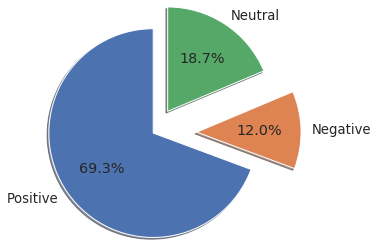

In [42]:
#ploting graph on the basis of sentiments
plt.pie([pos_review,neg_review,nut_review], labels=["Positive","Negative","Neutral"]   ,     
        startangle=90, shadow = True, explode = (0, 0.5, 0.3), 
        radius = 1.2, autopct = '%1.1f%%') 

In [48]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
#build graph for RNN
#uses LSTM memory cell
lstm_size = 64
lstm_layers = 1
batch_size = 128
learning_rate = 0.001

graph = tf.Graph()

# create the input and label placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

#create the first layer (embedding)
embed_size = 50 #embedding layer size

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((len(reviews_messages_array), embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

print('finished initializing params and creating embedding layers')

finished initializing params and creating embedding layers


In [49]:
#create the lstm layer
with graph.as_default():
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    #adding a drop out layer
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    #stack up the layer
    cell_layers = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
    #get the initial state for assigning     
    init_state = cell_layers.zero_state(batch_size, tf.float32)

print('finished creating lstm layers')

AttributeError: module 'tensorflow_core.compat.v1' has no attribute 'contrib'